In [1]:
import os

# Get the notebook's directory
SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
# Get repository root (two levels up from script directory)
REPO_ROOT = os.path.dirname(os.path.dirname(SCRIPT_DIR))

# data path for step 2
DIM = 128
CLS_NB = 3

# Define paths relative to REPO_ROOT
root = os.path.join(REPO_ROOT, "Data/step1_train_phase1/features/")
train_root = os.path.join(root, "train/")
val_root = os.path.join(root, "val/")
best_model = os.path.join(REPO_ROOT, "Data/step1_train_phase1/fuse_ckpt/model_0.9489462970044914.ckpt")

raw_data_loc = os.path.join(REPO_ROOT, "Data/processed/G0_arrest/TrVal_dataset_QuiescenceStatus.pkl")

import sys
code_loc = os.path.join(REPO_ROOT, "code/")
save_loc = os.path.join(REPO_ROOT, "Data/step2_vis_performance/")
sys.path.append(code_loc)

In [2]:
import dill
with open(raw_data_loc,"rb") as f:
    [trainset,valset,_,label_dict] = dill.load(f)


In [3]:
# 数据转换：从CSR稀疏矩阵转换为密集矩阵
X_train = trainset.data.toarray()
y_train = trainset.label
X_val = valset.data.toarray()
y_val = valset.label

In [4]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [5]:
all_classifiers = {}
methods_name = ["knn","rf","ada"] #
# PCA降维
pca = PCA(n_components=0.95)  # 保留95%的方差
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# 训练KNN模型（这里可以调整KNN的参数）
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)

all_classifiers["knn"] = knn

# 训练随机森林模型（这里可以调整随机森林的参数）
rf = RandomForestClassifier()
rf.fit(X_train_pca, y_train)

all_classifiers["rf"] = rf

# ada boost
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_train_pca, y_train)

all_classifiers["ada"] = ada


all_scores = {}
from sklearn.multiclass import OneVsRestClassifier



/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:

for method in methods_name:
    print(f" method {method} is infering..")
    y_score = all_classifiers[method].predict_proba(X_val_pca)
    print(y_score)
    all_scores[method] = y_score

 method knn is infering..
[[0.6 0.4 0. ]
 [0.8 0.  0.2]
 [0.6 0.4 0. ]
 ...
 [1.  0.  0. ]
 [0.8 0.2 0. ]
 [1.  0.  0. ]]
 method rf is infering..
[[0.66 0.3  0.04]
 [0.38 0.21 0.41]
 [0.73 0.14 0.13]
 ...
 [0.64 0.14 0.22]
 [0.32 0.27 0.41]
 [0.94 0.04 0.02]]
 method ada is infering..
[[0.36148401 0.33261199 0.305904  ]
 [0.35812277 0.28761223 0.354265  ]
 [0.35479092 0.34804371 0.29716537]
 ...
 [0.36069528 0.30867696 0.33062776]
 [0.36034925 0.30556589 0.33408486]
 [0.36595312 0.30380533 0.33024155]]


In [7]:
def get_roc_data(y_train,y_val,y_score,name, type:str="macro"):
    from sklearn.metrics import roc_auc_score, roc_curve, auc
    from sklearn.preprocessing import label_binarize
    
    # 使用OneVsRest方法处理多分类问题
    # 计算每一类的ROC AUC
    y_val_bin = label_binarize(y_val, classes=np.unique(y_train))
    n_classes = y_val_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 假设fpr, tpr和roc_auc是我们之前计算得到的，这里使用它们来计算宏观平均ROC
    # 计算所有类别的平均FPR
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # 然后对所有类别的TPR进行插值，使它们具有相同的FPR
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # 计算平均TPR
    mean_tpr /= n_classes

    if type == "macro":
        # 计算宏观平均ROC AUC
        macro_roc_auc = auc(all_fpr, mean_tpr)

        return name, all_fpr, mean_tpr, macro_roc_auc
    elif type == "micro":
        # 计算微观平均ROC曲线和ROC AUC
        micro_fpr, micro_tpr, _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
        micro_roc_auc = auc(micro_fpr, micro_tpr)
        return name, micro_fpr, micro_tpr, micro_roc_auc
    
    else:
        raise ValueError("type must be 'macro' or 'micro'")

In [8]:
def plot_all_roc(names, fprs, tprs, aucs, loc= "/home/shi/WorkSpace/projects/DormancyLM_workspace/Data/step2_vis_performance/"):
    import numpy as np
    import matplotlib.pyplot as plt
    colors = ['#0c1b33', '#437c90', '#8b212c', '#f55141', '#ffa360']
    # 绘制所有类别的ROC曲线
    plt.figure()
    for i, ( n, fpr,tpr,auc) in enumerate(zip(names, fprs, tprs, aucs)):
        current_color = colors[i]
        label_fix = f"{n} (area ="
        plt.plot(fpr, tpr, label=label_fix+'{0:0.2f})'
                ''.format(auc),color=current_color, linewidth=1)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC with different methods')
    plt.legend(loc="lower right")
    plt.savefig(loc+"baseline_compare.pdf")
    plt.show()


In [9]:
names = []
fprs = []
tprs = []
aucs = []

for method in methods_name:
    print(f" method {method} is plotting..")
    y_score = all_scores[method]
    name, fpr, tpr, auc = get_roc_data(y_train,y_val,y_score,method)
    names.append(name)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)


 method knn is plotting..
 method rf is plotting..
 method ada is plotting..


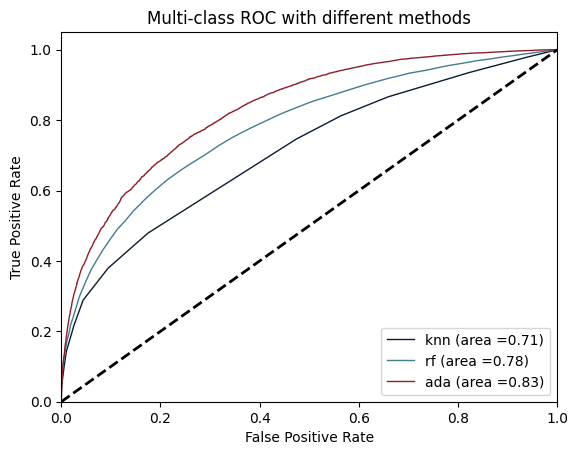

In [10]:
plot_all_roc(names, fprs, tprs, aucs)

In [13]:
import torch.nn as nn
class FuseNet(nn.Module):
    def __init__(self,in_dim=DIM*CLS_NB, dropout = 0., h_dim = DIM, out_dim =CLS_NB, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        if out_key == "fc1":
            return x

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        if out_key == "fc2":
            return x
        x = self.fc3(x)
        if out_key == "all":
            return x
        else:
            raise ValueError("out_key must be one of 'fc1', 'fc2', 'all'")
    

# 从文件夹中读取所有类的feature matrix
import pickle
import numpy as np


read_list = ["cls0","cls1","cls2"]
#-->train
train_feat_list = []
for i in range(len(read_list)):
    with open(train_root+read_list[i]+".pkl","rb") as f:
        [feat,label] = pickle.load(f)
        train_feat_list.append(feat)
train_label = label
print(len(train_feat_list),train_feat_list[0].shape,train_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
train_feat = np.concatenate(train_feat_list,axis=1) 

#-->val
val_feat_list = []
for i in range(len(read_list)):
    with open(val_root+read_list[i]+".pkl","rb") as f:
        [feat,label] = pickle.load(f)
        val_feat_list.append(feat)
val_label = label
print(len(val_feat_list),val_feat_list[0].shape,val_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
val_feat = np.concatenate(val_feat_list,axis=1)

# train model 
import torch

train_feat = torch.from_numpy(train_feat).float()
train_label = torch.from_numpy(train_label).long() 
# label from [sample_nb,1] -> [sample_nb,class_nb]
train_label = torch.zeros(train_label.shape[0],5).scatter_(1,train_label,1)


val_feat = torch.from_numpy(val_feat).float()
val_label = torch.from_numpy(val_label).long()
# label from [sample_nb,1] -> [sample_nb,class_nb]
val_label = torch.zeros(val_label.shape[0],5).scatter_(1,val_label,1)


# get Dataset and DataLoader
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(train_feat,train_label)
valset = TensorDataset(val_feat,val_label)

trainloader = DataLoader(trainset,batch_size=DIM,shuffle=True)
valloader = DataLoader(valset,batch_size=DIM,shuffle=True)

# get model
model = FuseNet(in_dim=DIM*CLS_NB, dropout = 0., h_dim = DIM, out_dim = CLS_NB, )


model.load_state_dict(torch.load(best_model))

# strat train
from tqdm import tqdm
# roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
model.to("cuda")
best_roc  = 0

# eval
model.eval()
pred_list = []
label_list = []
feat_list = []
for feat,label in tqdm(valloader):
    feat = feat.to("cuda")
    label = label.to("cuda")
    pred = model(feat)
    #pred = F.tanh(pred)+1
    pred=F.softmax(pred,dim=1)
    pred = pred.detach().cpu().numpy()
    pred_list.append(pred)
    label_list.append(label.detach().cpu().numpy())
    feat_list.append(feat.detach().cpu().numpy())
pred_list = np.concatenate(pred_list,axis=0)
label_list = np.concatenate(label_list,axis=0)
emb2_list = np.concatenate(feat_list,axis=0)
# from pred_list and label_list get roc_auc for each class
#order =['G0_arrested', 'Slow_cycling', 'Fast_cycling']
# 构建 reverse_label_dict
reverse_label_dict = {v: k for k, v in label_dict.items()}

# 指定的顺序
order =['G0_arrested', 'Slow_cycling', 'Fast_cycling']
from sklearn.metrics import roc_curve, auc
from scipy import interp
# 计算每个类别的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, label in enumerate(order):
    class_index = label_dict[label]
    fpr[label], tpr[label], _ = roc_curve(label_list[:, class_index], pred_list[:, class_index])
    roc_auc[label] = auc(fpr[label], tpr[label])

# 计算微观平均ROC曲线和AUC
all_fpr = np.unique(np.concatenate([fpr[label] for label in order]))
mean_tpr = np.zeros_like(all_fpr)
for label in order:
    mean_tpr += interp(all_fpr, fpr[label], tpr[label])
mean_tpr /= len(order)
mean_auc = auc(all_fpr, mean_tpr)

# add to list
names.append("EMT-LM")
fprs.append(all_fpr)
tprs.append(mean_tpr)
aucs.append(mean_auc)

3 (68599, 128) (68599, 1)
3 (17150, 128) (17150, 1)


100%|██████████| 134/134 [00:00<00:00, 214.03it/s]
/tmp/ipykernel_110260/377464984.py:140: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


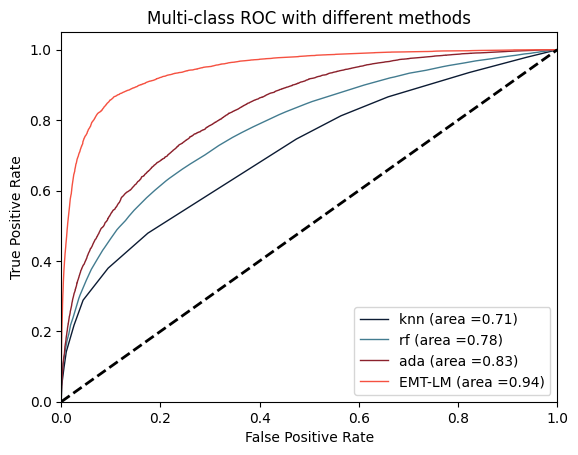

In [14]:
plot_all_roc(names, fprs, tprs, aucs)